In [12]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Point Source

In [3]:
%matplotlib inline

from openquake.hazardlib.source import PointSource, AreaSource, SimpleFaultSource, ComplexFaultSource, CharacteristicFaultSource
from openquake.hazardlib.mfd import TruncatedGRMFD, EvenlyDiscretizedMFD
from openquake.hazardlib.scalerel import WC1994
from openquake.hazardlib.geo import Point, NodalPlane, Polygon, Line, ComplexFaultSurface
from openquake.hazardlib.geo.surface import PlanarSurface
from openquake.hazardlib.pmf import PMF
from openquake.hazardlib.tom import PoissonTOM

import numpy
from matplotlib import pyplot
from matplotlib import collections
from mpl_toolkits.basemap import Basemap


In /home/gamant/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/gamant/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/gamant/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/gamant/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/gamant/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

In [14]:
def get_map_projection(src):
    """
    Return map projection specific to source.
    """
    # extract rupture enclosing polygon (considering a buffer of 10 km)
    rup_poly = src.get_bounding_box(10.) #modified
    min_lon = rup_poly[0]
    max_lon = rup_poly[2]
    min_lat = rup_poly[1]
    max_lat = rup_poly[3]
    
    # create map projection
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat,
                llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l')
    print("www",m)
    return min_lon, max_lon, min_lat, max_lat, m

In [15]:
def get_planar_surface_boundary(surf):
    """
    Return coordinates of planar surface boundary
    """
    boundary_lons = numpy.array(
        [surf.top_left.longitude, surf.top_right.longitude,
         surf.bottom_right.longitude, surf.bottom_left.longitude, surf.top_left.longitude]
    )
    boundary_lats = numpy.array(
        [surf.top_left.latitude, surf.top_right.latitude,
         surf.bottom_right.latitude, surf.bottom_left.latitude, surf.top_left.latitude]
    )
    
    return boundary_lons, boundary_lats

In [6]:
def get_mesh_boundary(mesh):
    """
    Return coordinates of mesh boundary
    """
    boundary_lons = numpy.concatenate((mesh.lons[0, :], mesh.lons[1:, -1], mesh.lons[-1,:-1][::-1], mesh.lons[:-1, 0][::-1]))
    boundary_lats = numpy.concatenate((mesh.lats[0, :], mesh.lats[1:, -1], mesh.lats[-1,:-1][::-1], mesh.lats[:-1, 0][::-1]))
    
    return boundary_lons, boundary_lats

In [17]:
# define Point Source
src = PointSource(
    source_id='1',
    name='point',
    tectonic_region_type='Active Shallow Crust',
    mfd=TruncatedGRMFD(min_mag=5., max_mag=6.5, bin_width=0.2, a_val=0.01, b_val=0.98),
    rupture_mesh_spacing=2.,
    magnitude_scaling_relationship=WC1994(),
    rupture_aspect_ratio=1.,
    temporal_occurrence_model=PoissonTOM(50.),
    upper_seismogenic_depth=2.,
    lower_seismogenic_depth=12.,
    location=Point(9.1500, 45.1833),
    nodal_plane_distribution=PMF([(0.5, NodalPlane(strike=45, dip=50, rake=0)), (0.5, NodalPlane(strike=135, dip=50, rake=0))]),
    hypocenter_distribution=PMF([(1, 7.)])
)

a=src.get_bounding_box(10)
help(src)

Help on PointSource in module openquake.hazardlib.source.point object:

class PointSource(openquake.hazardlib.source.base.ParametricSeismicSource)
 |  Point source typology represents seismicity on a single geographical
 |  location.
 |  
 |  :param upper_seismogenic_depth:
 |      Minimum depth an earthquake rupture can reach, in km.
 |  :param lower_seismogenic_depth:
 |      Maximum depth an earthquake rupture can reach, in km.
 |  :param location:
 |      :class:`~openquake.hazardlib.geo.point.Point` object
 |      representing the location of the seismic source.
 |  :param nodal_plane_distribution:
 |      :class:`~openquake.hazardlib.pmf.PMF` object with values
 |      that are instances
 |      of :class:`openquake.hazardlib.geo.nodalplane.NodalPlane`.
 |      Shows the distribution
 |      of probability for rupture to have the certain nodal plane.
 |  :param hypocenter_distribution:
 |      :class:`~openquake.hazardlib.pmf.PMF` with values being float
 |      numbers in km rep

In [18]:
# loop over ruptures, extract rupture surface boundary and magnitude
min_lon, max_lon, min_lat, max_lat, m = get_map_projection(src)

boundaries = []
mags = []
for rup in src.iter_ruptures():
    surf = rup.surface
    mag = rup.mag

    boundary_lons, boundary_lats = get_planar_surface_boundary(surf)
    xx, yy = m(boundary_lons, boundary_lats)
    boundaries.append([(x, y) for x, y in zip(xx, yy)])
    mags.append(mag)

www <mpl_toolkits.basemap.Basemap object at 0x7f2bb08e1eb8>


Text(0.5, 1.0, 'Point Source Ruptures')

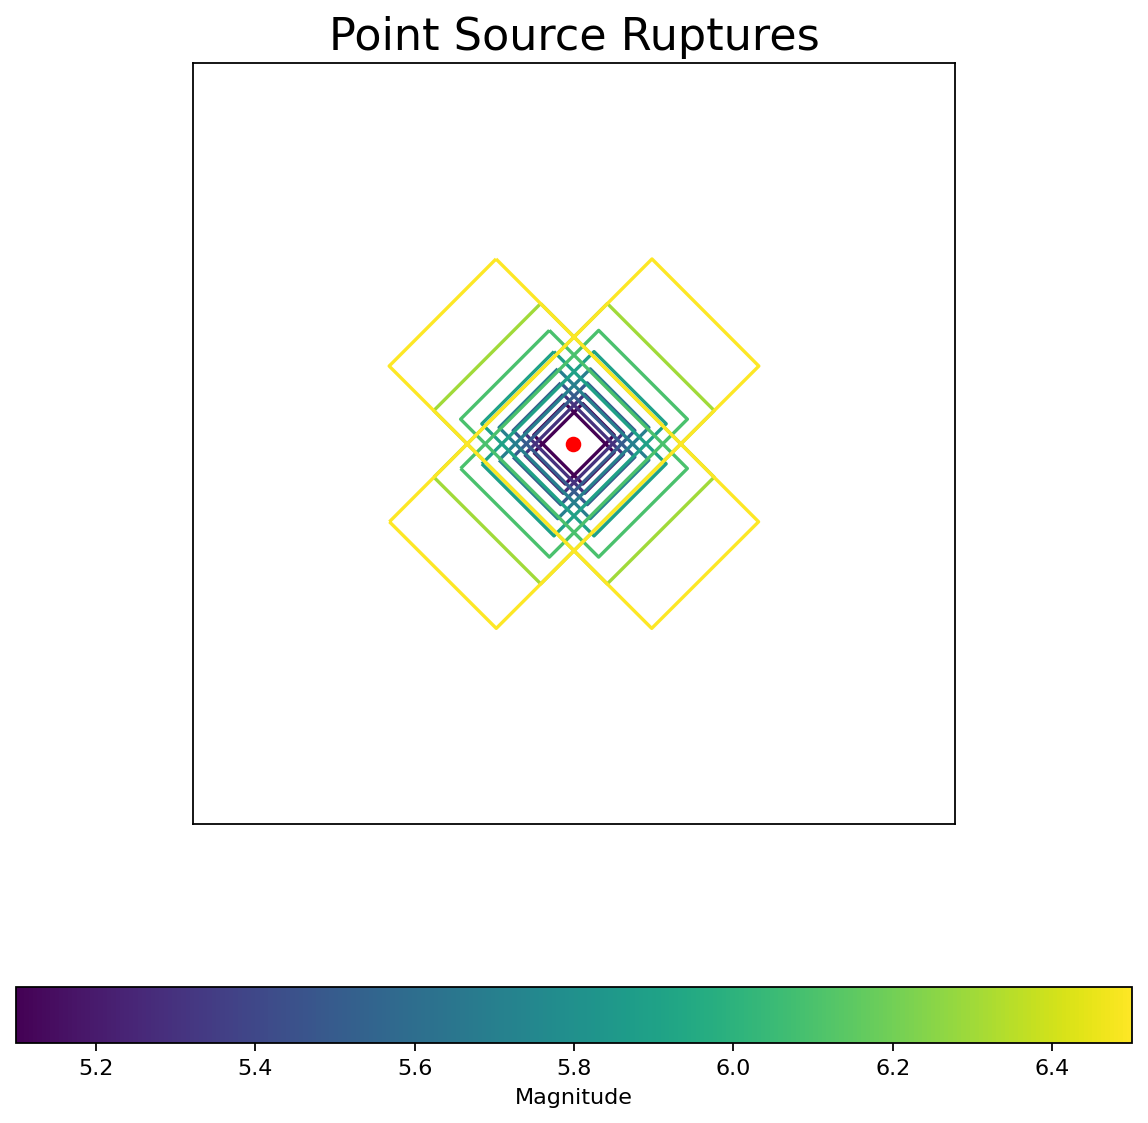

In [19]:

# plot rupturs. Color proportional to magnitude
fig1 = pyplot.figure(figsize=(9, 9), dpi=160)

# m.drawparallels(numpy.arange(min_lat, max_lat, 0.1), labels=[True, False, False, True])
# m.drawmeridians(numpy.arange(min_lon, max_lon, 0.1), labels=[True, False, False, True])
m.drawcoastlines()
m.drawcountries()

x, y = m(src.location.longitude, src.location.latitude)
m.plot(y, y, marker='o', color='red')

bounds = collections.LineCollection(boundaries)
bounds.set_array(numpy.array(mags))
pyplot.gca().add_collection(bounds)

cb = pyplot.colorbar(bounds, orientation='horizontal')
cb.set_label('Magnitude')
pyplot.title('Point Source Ruptures', fontsize=20)

# Simple Fault

In [1]:
def get_map_projection_sf(src):
    """
    Return map projection specific to source.
    """
    # extract rupture enclosing polygon (considering a buffer of 10 km)
    rup_poly = src.polygon.dilate(10)
    min_lon = numpy.min(rup_poly.lons)
    max_lon = numpy.max(rup_poly.lons)
    min_lat = numpy.min(rup_poly.lats)
    max_lat = numpy.max(rup_poly.lats)
    
    # create map projection
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat,
                llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l')

    return min_lon, max_lon, min_lat, max_lat, m

In [4]:
src_sf = SimpleFaultSource(
    source_id='1',
    name='simple fault',
    tectonic_region_type='active shallow crust',
    mfd=TruncatedGRMFD(min_mag=5., max_mag=6.5, bin_width=0.2, a_val=3.45, b_val=0.98),
    rupture_mesh_spacing=2.,
    magnitude_scaling_relationship=WC1994(),
    rupture_aspect_ratio=1.,
    temporal_occurrence_model=PoissonTOM(50.),
    upper_seismogenic_depth=2.,
    lower_seismogenic_depth=7.,
    fault_trace=Line([Point(9.21602706445, 45.1555287905), Point(9.25645636929, 45.1877167851),
                      Point(9.29688464252, 45.2199047798), Point(9.35715705075, 45.2398017764),
                      Point(9.42902686305, 45.2401237764), Point(9.47246500782, 45.2381597767),
                      Point(9.51590215304, 45.236194777), Point(9.56736930079, 45.2307927779),
                      Point(9.61883544823, 45.2253897788), Point(9.67030259419, 45.2199877797),
                      Point(9.72270625188, 45.2033947825), Point(9.77510990175, 45.1868007853),
                      Point(9.83238881096, 45.1680237884), Point(9.88966771001, 45.1492457915),
                      Point(9.94694559775, 45.1304687947), Point(10.0042244753, 45.1116907978)]),
    dip=30.,
    rake=90.
)

In [7]:
# loop over ruptures, extract rupture surface boundary and magnitude
min_lon, max_lon, min_lat, max_lat, m = get_map_projection_sf(src_sf)

boundaries = []
mags = []

for rup in src_sf.iter_ruptures():
    surf = rup.surface
    mesh = surf.mesh
    mag = rup.mag

    boundary_lons, boundary_lats = get_mesh_boundary(mesh)
    xx, yy = m(boundary_lons, boundary_lats)

    boundaries.append([(x, y) for x, y in zip(xx, yy)])
    mags.append(mag)

boundaries = numpy.array(boundaries)
mags = numpy.array(mags)


/home/gamant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


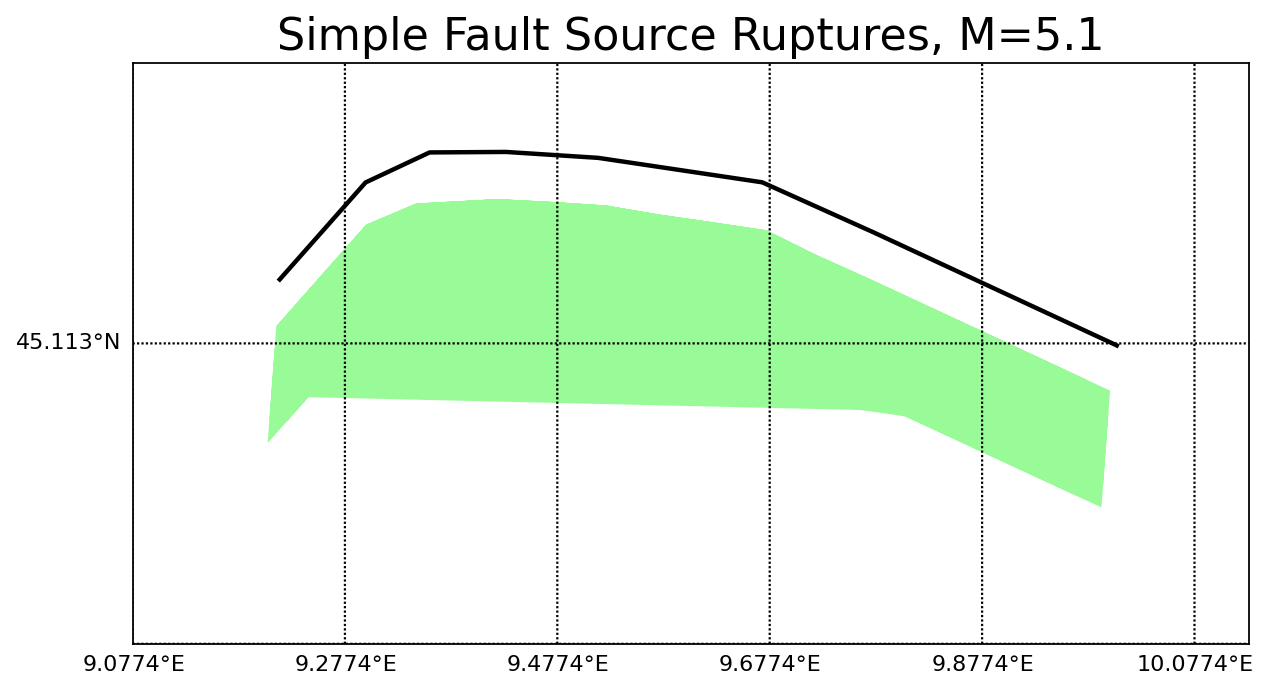

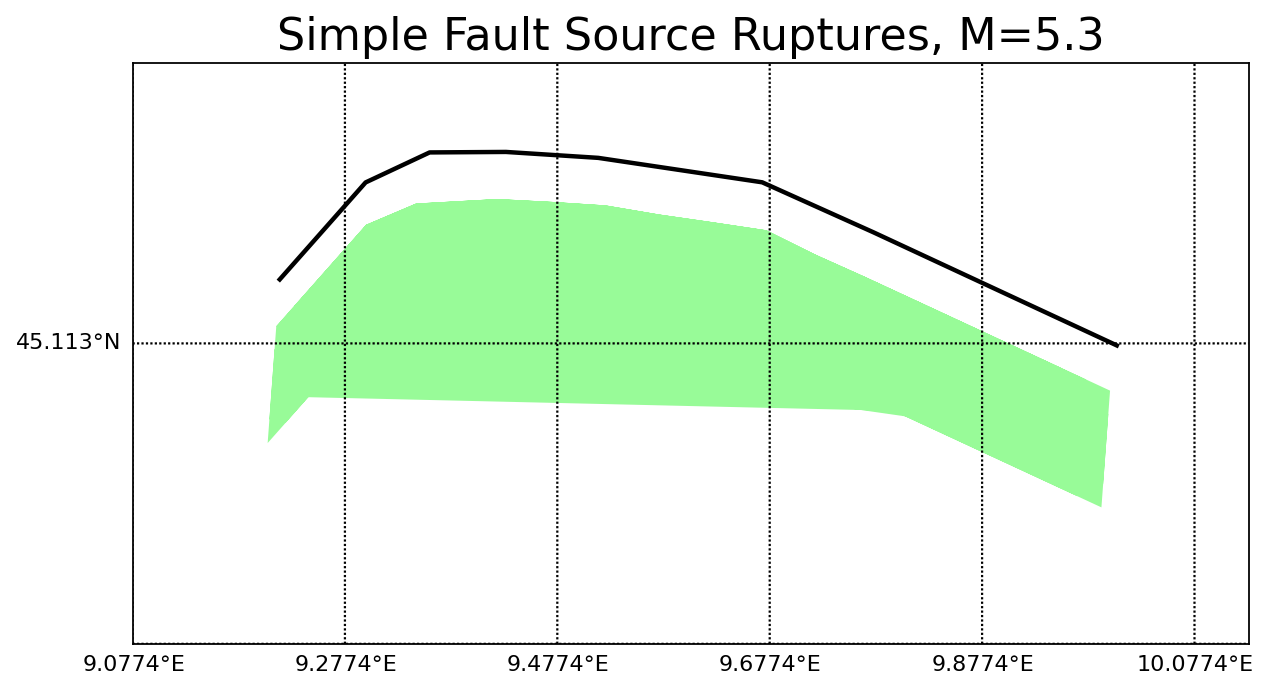

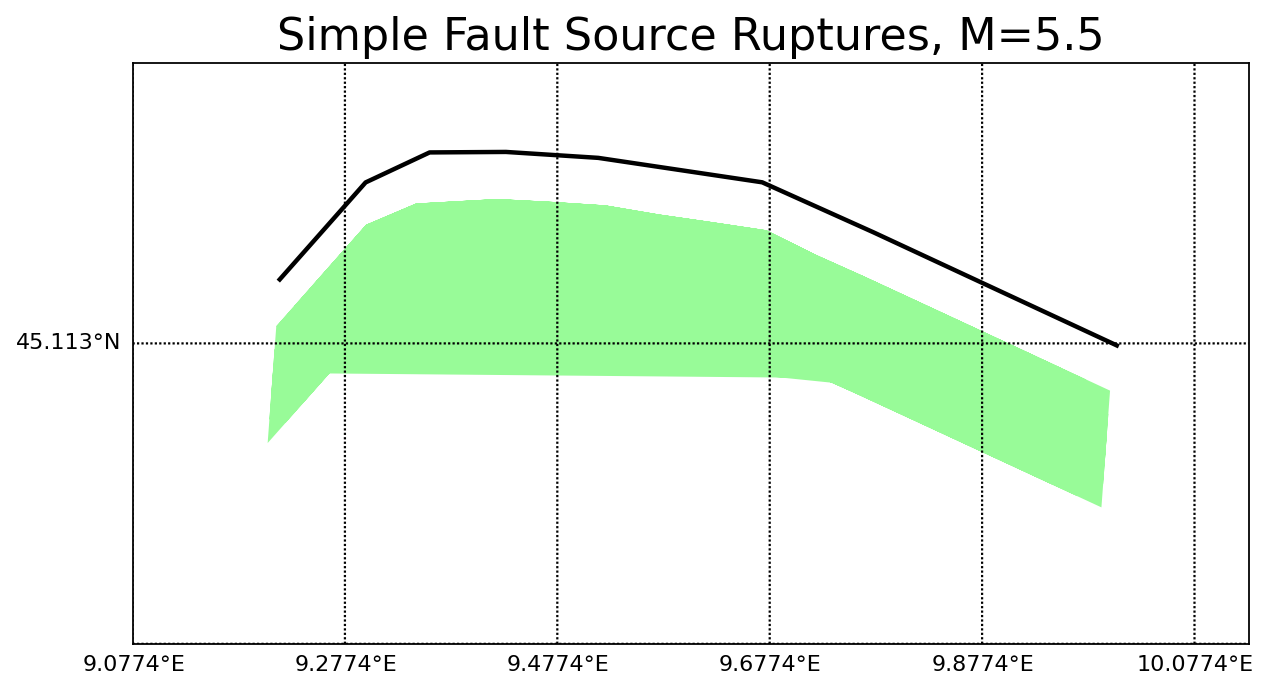

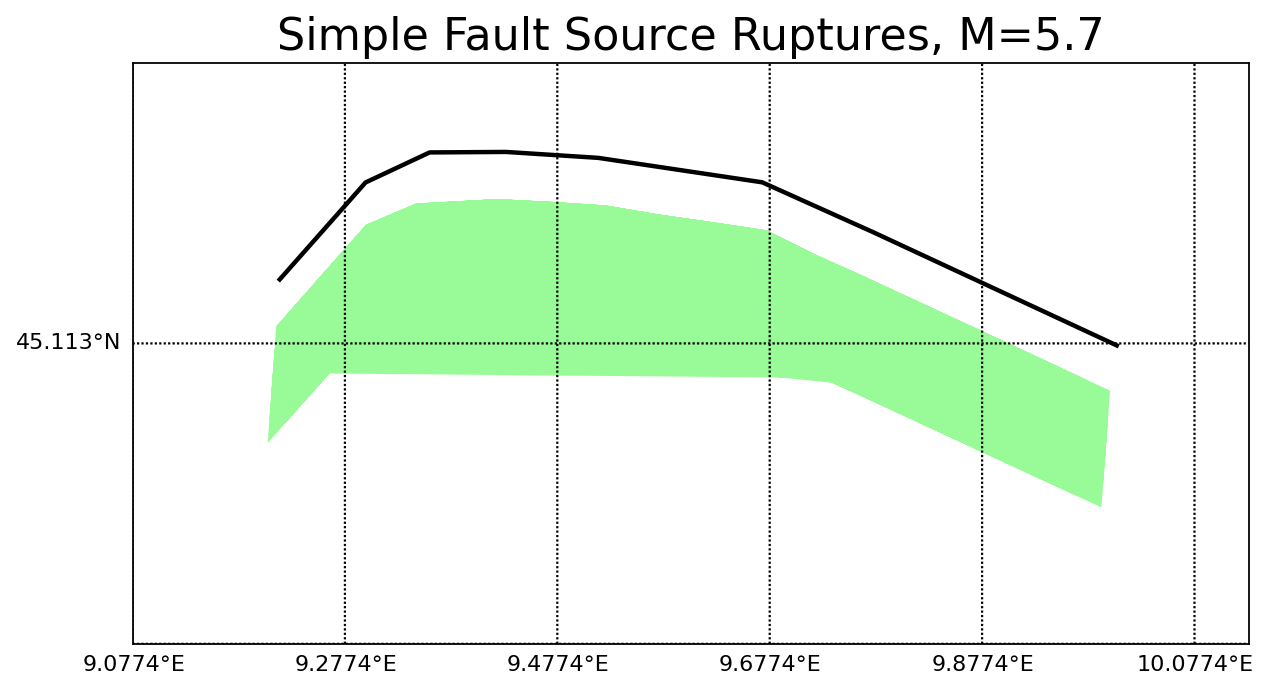

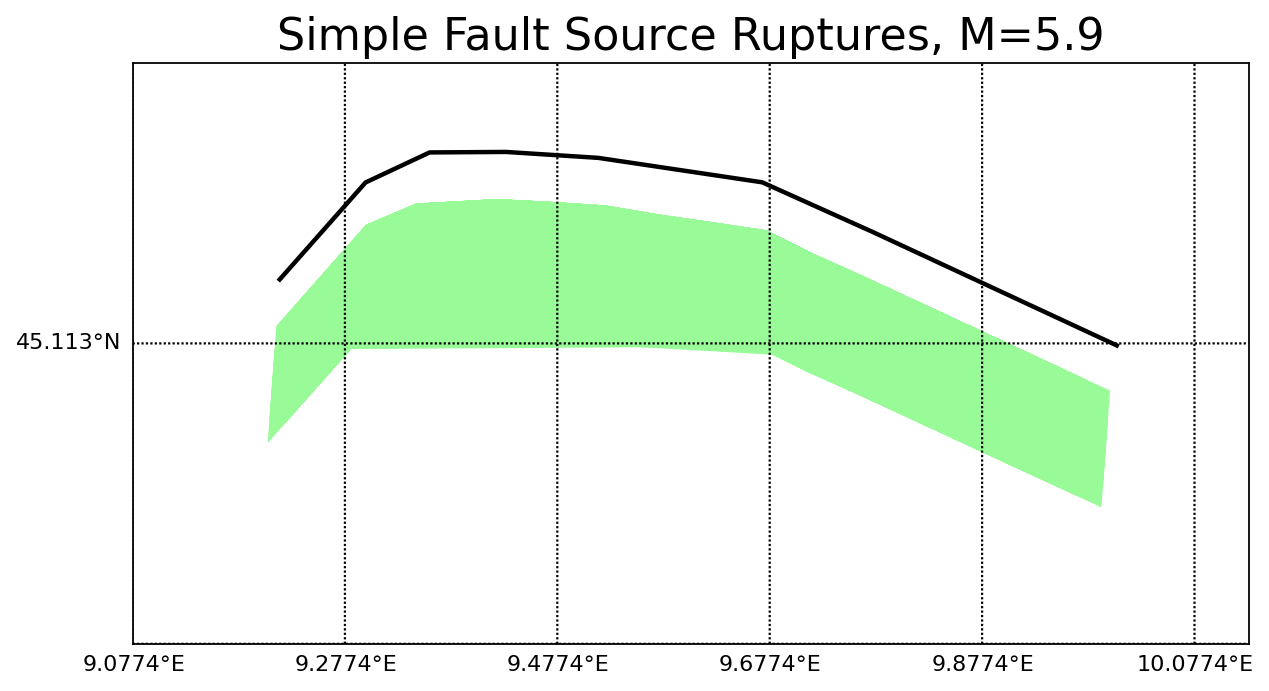

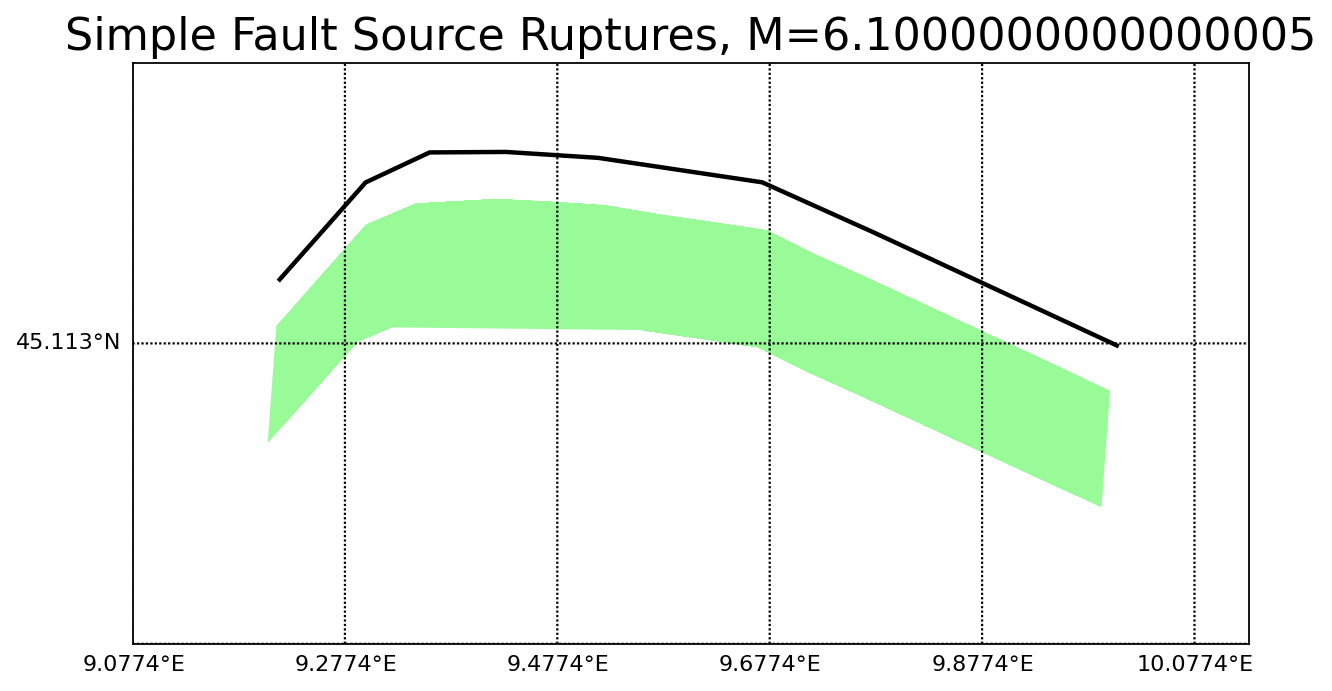

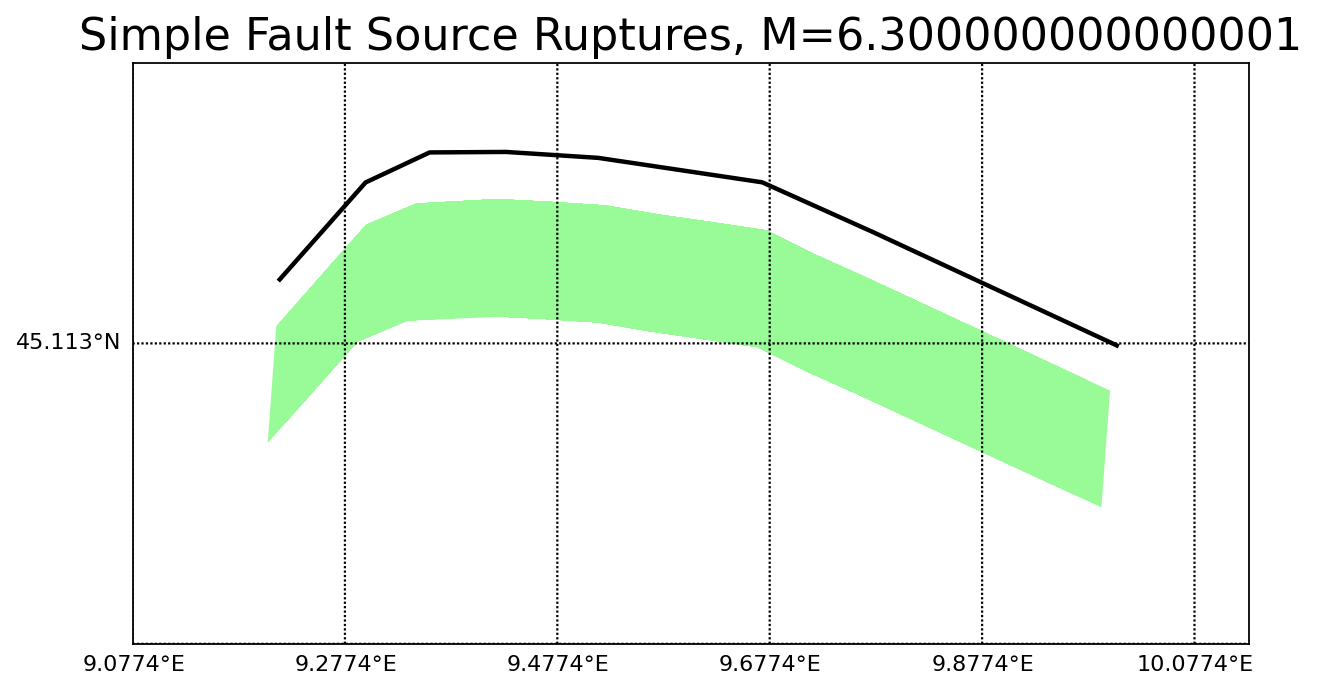

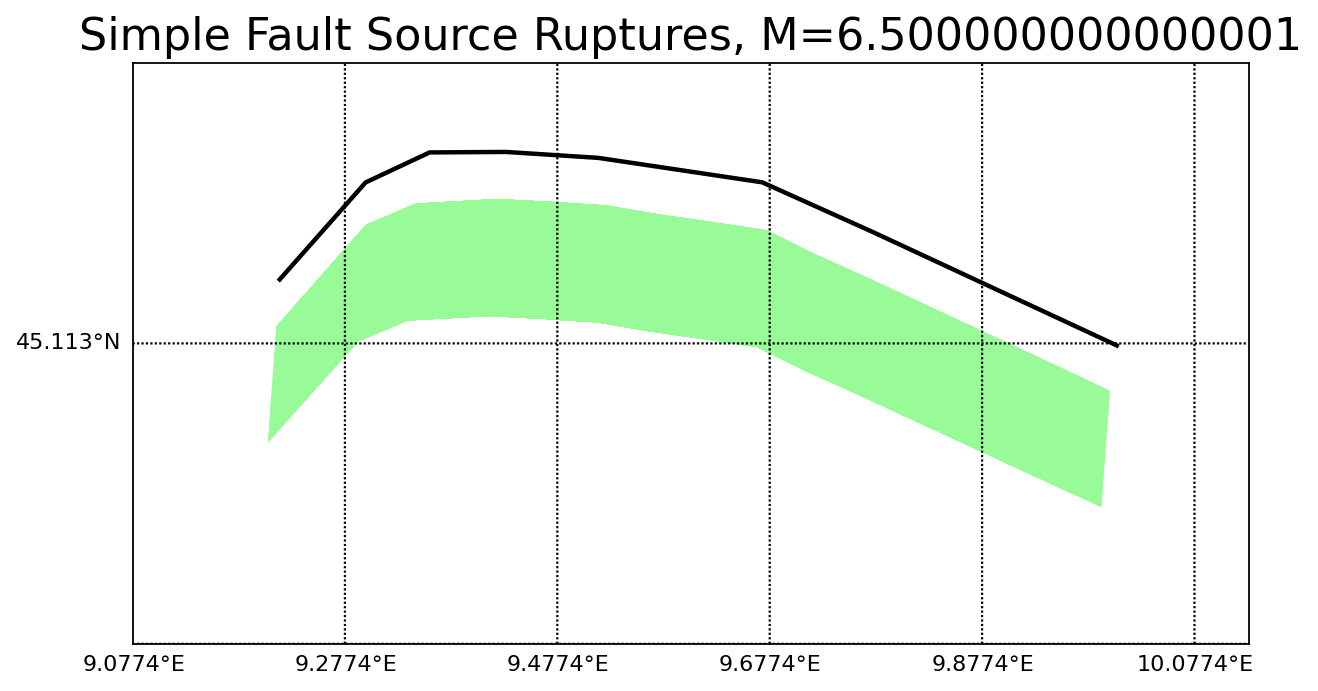

In [8]:
unique_mags = numpy.unique(mags)
for mag in unique_mags:
    idx = mags == mag
    fig = pyplot.figure(figsize=(9, 9), dpi=160)
    
    m.drawparallels(numpy.arange(min_lat, max_lat, 0.2), labels=[True, False, False, True])
    m.drawmeridians(numpy.arange(min_lon, max_lon, 0.2), labels=[True, False, False, True])
    m.drawcoastlines()
    m.drawcountries()
    
    # extract and plot fault trace
    lons = [p.longitude for p in src_sf.fault_trace.points]
    lats = [p.latitude for p in src_sf.fault_trace.points]
    x, y = m(lons, lats)
    m.plot(x, y, linewidth=2, color='black')
    
    nl = []
    for i in boundaries[idx]:
        for j in i:
            nl.append([j[0],j[1]])
            
    bounds = collections.PolyCollection([nl], facecolors='palegreen')
    pyplot.gca().add_collection(bounds)
    
    
    pyplot.title('Simple Fault Source Ruptures, M=%s' % mag, fontsize=20)
